In [11]:
import pandas as pd
import os 
from collections import defaultdict,Counter
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import math
from nltk.metrics import edit_distance
import random
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Randhir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
pip install wordcloud 

Note: you may need to restart the kernel to use updated packages.


In [15]:
from wordcloud import WordCloud


# Load data 

In [ ]:

# Load all text files from the dataset
def load_hinglish_data(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as f:
                data.extend(f.readlines())
    return [line.strip() for line in data if line.strip()]

# Load data
hinglish_data = load_hinglish_data(r"C:\Users\Randhir\Desktop\HINGLISH SMART TEXT PREDICTOR")
print(f"Loaded {len(hinglish_data)} Hinglish sentences")

# Cleaning text 

In [12]:
def clean_hinglish_text(text):
    """
    Clean and normalize Hinglish text
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters except for Hindi and basic punctuation
    text = re.sub(r'[^\w\s\u0900-\u097F.,!?]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Normalize repeated characters (e.g., "loooove" -> "love")
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    return text

# Clean all sentences
hinglish_data_clean = [clean_hinglish_text(sentence) for sentence in hinglish_data]

# Create a DataFrame for analysis
df = pd.DataFrame({'text': hinglish_data_clean})
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(len)
df['language_mix'] = df['text'].apply(lambda x: 'Mixed' if re.search(r'[a-zA-Z]', x) and re.search(r'[\u0900-\u097F]', x) else ('English' if re.search(r'[a-zA-Z]', x) else 'Hindi'))

print("\nBasic Statistics:")
print(f"Total sentences: {len(df)}")
print(f"Average word count: {df['word_count'].mean():.1f}")
print(f"Average character count: {df['char_count'].mean():.1f}")
print("\nLanguage Distribution:")
print(df['language_mix'].value_counts())


Basic Statistics:
Total sentences: 21941
Average word count: 37.3
Average character count: 218.3

Language Distribution:
language_mix
English    19602
Mixed       1720
Hindi        619
Name: count, dtype: int64


# data visulaisation 


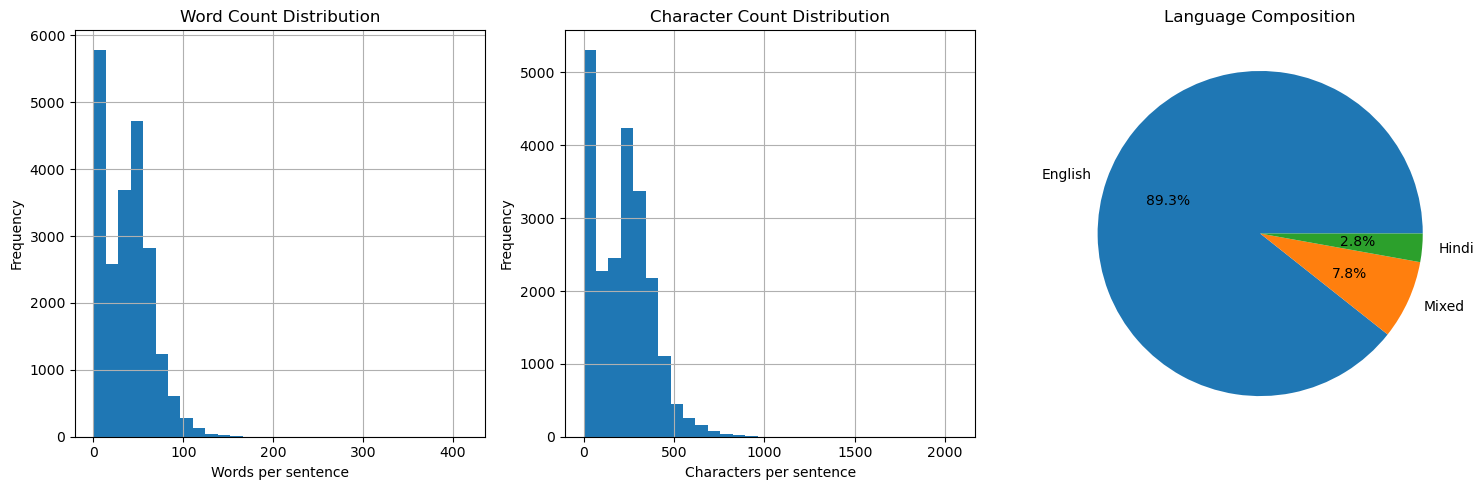

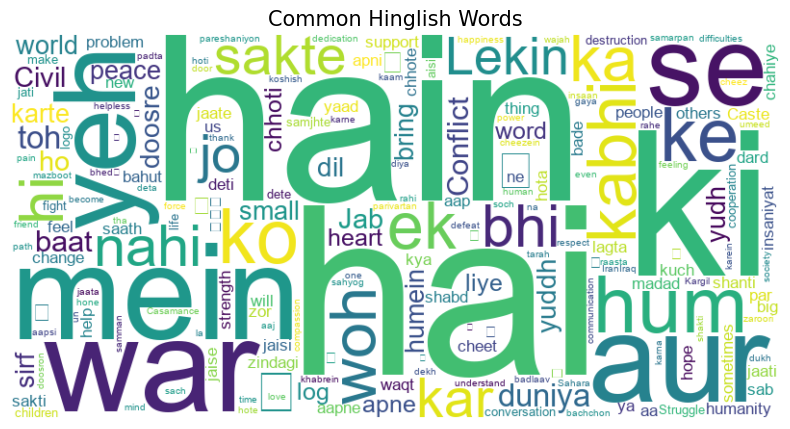

In [16]:
plt.figure(figsize=(15, 5))

# Word count distribution
plt.subplot(1, 3, 1)
df['word_count'].hist(bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Words per sentence')
plt.ylabel('Frequency')

# Character count distribution
plt.subplot(1, 3, 2)
df['char_count'].hist(bins=30)
plt.title('Character Count Distribution')
plt.xlabel('Characters per sentence')
plt.ylabel('Frequency')

# Language mix pie chart
plt.subplot(1, 3, 3)
df['language_mix'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Language Composition')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Generate word clouds for Hinglish words
def generate_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         font_path='arial',  # Use a font that supports Hindi
                         collocations=False).generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Word cloud for mixed sentences
mixed_texts = df[df['language_mix'] == 'Mixed']['text']
generate_wordcloud(mixed_texts, 'Common Hinglish Words')

# Tokenization

In [18]:


# Tokenize the cleaned data
def tokenize_hinglish(text):
    # Simple tokenizer that handles Hinglish code-mixing
    tokens = re.findall(r'[\w\u0900-\u097F]+|[.,!?]', text.lower())
    return [token for token in tokens if token.strip()]

df['tokens'] = df['text'].apply(tokenize_hinglish)

# Split into train and test sets
train_data, test_data = train_test_split(df['tokens'], test_size=0.2, random_state=42)

print(f"\nTraining sentences: {len(train_data)}")
print(f"Test sentences: {len(test_data)}")

# Vocabulary analysis
all_tokens = [token for tokens in train_data for token in tokens]
vocab = Counter(all_tokens)
print(f"\nVocabulary size: {len(vocab)}")
print("Most common tokens:")
print(vocab.most_common(20))


Training sentences: 17552
Test sentences: 4389

Vocabulary size: 13750
Most common tokens:
[('.', 32612), (',', 28187), ('the', 20729), ('of', 13539), ('hai', 11876), ('aur', 11692), ('a', 10531), ('and', 10486), ('hain', 9352), ('ki', 9340), ('to', 7872), ('ke', 7516), ('war', 7444), ('mein', 7321), ('in', 6695), ('ko', 6255), ('yeh', 5367), ('hum', 5340), ('ek', 5325), ('se', 5188)]


# Handling words 

In [19]:
# Handle rare words (replace with <UNK>)
min_count = 3
rare_words = {word for word, count in vocab.items() if count < min_count}

def replace_rare_words(tokens):
    return [token if token not in rare_words else '<UNK>' for token in tokens]

train_data = train_data.apply(replace_rare_words)
test_data = test_data.apply(replace_rare_words)

# Update vocabulary
vocab = Counter(token for tokens in train_data for token in tokens)
print(f"\nVocabulary size after handling rare words: {len(vocab)}")


Vocabulary size after handling rare words: 9245


In [20]:
# Add sentence boundaries
def add_boundaries(tokens, n=3):
    return ['<s>']*(n-1) + tokens + ['</s>']

# Prepare n-gram training data
train_data_ngram = train_data.apply(lambda x: add_boundaries(x, n=3))
test_data_ngram = test_data.apply(lambda x: add_boundaries(x, n=3))

# Save processed data
processed_data = {
    'train_data': train_data_ngram.tolist(),
    'test_data': test_data_ngram.tolist(),
    'vocab': vocab
}

import pickle
with open('hinglish_processed.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("\nData processing complete. Saved to 'hinglish_processed.pkl'")


Data processing complete. Saved to 'hinglish_processed.pkl'


# load the preprocessed data

# Ngram mOdel class 

# Train model 

In [54]:
import math
from collections import defaultdict, Counter

class NGramModel:
    def __init__(self, n, smoothing='kneser_ney', discount=0.75):
        self.n = n
        self.smoothing = smoothing
        self.discount = discount
        self.ngram_counts = defaultdict(Counter)
        self.context_counts = defaultdict(int)
        self.vocab = set()
        self.continuation_counts = defaultdict(int)
        self.total_words = 0

    def train(self, tokens_list):
        # First build vocabulary
        for tokens in tokens_list:
            self.vocab.update(tokens)
            self.total_words += len(tokens)
        
        # Then count ngrams
        for tokens in tokens_list:
            if len(tokens) < self.n:
                continue

            # Add sentence boundaries
            padded_tokens = ['<s>']*(self.n-1) + tokens + ['</s>']
            
            for i in range(len(padded_tokens) - self.n + 1):
                ngram = tuple(padded_tokens[i:i+self.n])
                context = ngram[:-1]
                word = ngram[-1]

                self.ngram_counts[context][word] += 1
                self.context_counts[context] += 1

                if self.n > 1:
                    self.continuation_counts[word] += 1

    def probability(self, context, word):
        context = tuple(context)
        
        # Handle unknown words
        if word not in self.vocab and word not in ['<s>', '</s>']:
            word = '<UNK>'

        if self.smoothing == 'kneser_ney':
            return self._kneser_ney_probability(context, word)
        elif self.smoothing == 'laplace':
            return (self.ngram_counts.get(context, {}).get(word, 0) + 1) / \
                   (self.context_counts.get(context, 0) + len(self.vocab))
        else:  # Maximum Likelihood
            context_count = self.context_counts.get(context, 0)
            if context_count == 0:
                return 1 / len(self.vocab)  # Fallback to uniform
            return self.ngram_counts[context].get(word, 0) / context_count

    def _kneser_ney_probability(self, context, word):
        # Continuation probability
        total_continuations = max(1, len(self.continuation_counts))
        p_continuation = self.continuation_counts.get(word, 0) / total_continuations

        if not context:  # Unigram case
            return p_continuation

        context_count = self.context_counts.get(context, 0)
        if context_count == 0:
            return p_continuation

        num_continuations = max(1, len(self.ngram_counts.get(context, {})))
        lambda_weight = self.discount * num_continuations / context_count

        if word in self.ngram_counts.get(context, {}):
            discounted = max(self.ngram_counts[context][word] - self.discount, 0)
            return discounted / context_count + lambda_weight * p_continuation
        else:
            return lambda_weight * p_continuation

    def perplexity(self, tokens):
        log_prob = 0.0
        N = 0
        
        # Add sentence boundaries
        padded_tokens = ['<s>']*(self.n-1) + tokens + ['</s>']
        
        for i in range(self.n-1, len(padded_tokens)):
            context = padded_tokens[i-self.n+1:i]
            word = padded_tokens[i]
            
            prob = self.probability(context, word)
            if prob <= 0:
                prob = 1e-10  # Avoid log(0)
            
            log_prob += math.log(prob)
            N += 1
        
        return math.exp(-log_prob / N) if N > 0 else float('inf')

# Improved tokenizer for Hinglish
def hinglish_tokenizer(sentence):
    # Basic tokenization with some common Hinglish patterns
    sentence = sentence.lower().strip()
    # Handle common contractions
    sentence = sentence.replace("'", " ' ").replace("n't", " n't")
    # Split on whitespace and punctuation
    tokens = []
    for word in sentence.split():
        # Handle common Hinglish word endings
        if word.endswith(('.', ',', '!', '?')):
            tokens.append(word[:-1])
            tokens.append(word[-1])
        else:
            tokens.append(word)
    return tokens

# Example usage
if __name__ == "__main__":
    # Sample data (replace with your actual data)
    hinglish_data = [
        "aaj kal ka mausam accha hai",
        "kya tum kal aaoge",
        "mera naam hai john",
        "aaj kal ka time bahut busy hai"
    ]
    
    # Preprocess all data
    tokenized_data = [hinglish_tokenizer(sentence) for sentence in hinglish_data]
    
    # Add OOV handling
    vocab = set(word for sentence in tokenized_data for word in sentence)
    tokenized_data = [[word if word in vocab else '<UNK>' for word in sentence] 
                     for sentence in tokenized_data]
    
    # Train models with proper smoothing
    unigram = NGramModel(1, smoothing='laplace')
    bigram = NGramModel(2, smoothing='kneser_ney')
    trigram = NGramModel(3, smoothing='kneser_ney')
    
    for model in [unigram, bigram, trigram]:
        model.train(tokenized_data)
    
    # Evaluate on sample sentences
    test_sentences = [
        "aaj kal ka",
        "mausam accha hai",
        "kya time hai"
    ]
    
    print("=== Perplexity Results ===")
    for sentence in test_sentences:
        tokens = hinglish_tokenizer(sentence)
        tokens = [word if word in vocab else '<UNK>' for word in tokens]
        
        print(f"\nSentence: '{sentence}'")
        print(f"Unigram: {unigram.perplexity(tokens):.2f}")
        print(f"Bigram:  {bigram.perplexity(tokens):.2f}")
        print(f"Trigram: {trigram.perplexity(tokens):.2f}")

=== Perplexity Results ===

Sentence: 'aaj kal ka'
Unigram: 10.92
Bigram:  2.54
Trigram: 2.34

Sentence: 'mausam accha hai'
Unigram: 13.37
Bigram:  4.61
Trigram: 7.18

Sentence: 'kya time hai'
Unigram: 13.37
Bigram:  7.32
Trigram: 8.26


# Next word prediction

In [55]:
def predict_next_words(model, context, top_k=5):
    context = tuple(hinglish_tokenizer(context)[-(model.n-1):])  # Get last n-1 words
    if context in model.ngram_counts:
        return model.ngram_counts[context].most_common(top_k)
    return []

# Example usage
context = "aaj ka mausam"
print("Next word predictions:", predict_next_words(bigram, context))

Next word predictions: [('accha', 1)]


# Auto correct suggestion

In [56]:
from nltk.metrics import edit_distance

def auto_correct(model, word, context, max_distance=2):
    suggestions = []
    context = tuple(hinglish_tokenizer(context)[-(model.n-1):])
    
    # Get vocabulary words similar to the input
    for vocab_word in model.vocab:
        if edit_distance(word, vocab_word) <= max_distance:
            # Calculate probability in context
            prob = model.probability(context, vocab_word)
            suggestions.append((vocab_word, prob))
    
    # Sort by probability and return top suggestions
    suggestions.sort(key=lambda x: x[1], reverse=True)
    return [word for word, prob in suggestions[:5]]

# Example usage
print("Auto-correct suggestions:", auto_correct(bigram, "mausm", "aaj ka"))

Auto-correct suggestions: ['mausam']


# TEXT GENERATION 

In [58]:
def generate_text(model, seed_text=None, max_length=20, temperature=1.0):
    # Initialize with seed text or sentence start
    if seed_text is None:
        context = ['<s>'] * (model.n - 1)
    else:
        seed_tokens = hinglish_tokenizer(seed_text)
        seed_tokens = [t if t in model.vocab else '<UNK>' for t in seed_tokens]
        context = ['<s>'] * max(0, model.n - 1 - len(seed_tokens)) + seed_tokens
    
    generated = list(context)
    
    for _ in range(max_length):
        current_context = tuple(generated[-(model.n-1):])
        
        # Get possible next words with probabilities
        candidates = {}
        if current_context in model.ngram_counts:
            for word, count in model.ngram_counts[current_context].items():
                candidates[word] = model.probability(current_context, word)
        
        # Fallback to lower-order n-grams if no candidates
        if not candidates and len(current_context) > 0:
            current_context = current_context[1:]  # Try shorter context
            for word in model.vocab:
                prob = model.probability(current_context, word)
                if prob > 0:
                    candidates[word] = prob
        
        if not candidates:
            break
        
        # Apply temperature scaling
        words, probs = zip(*candidates.items())
        scaled_probs = [p**(1/temperature) for p in probs]
        norm_probs = [p/sum(scaled_probs) for p in scaled_probs]
        
        # Sample next word
        next_word = random.choices(words, weights=norm_probs, k=1)[0]
        
        if next_word == '</s>':
            break
            
        generated.append(next_word)
    
    # Clean up the output
    result = ' '.join(generated[model.n-1:])
    result = result.replace(' ,', ',').replace(' .', '.').replace(' !', '!')
    return result.capitalize()

# Example usage with different temperatures
print("\n=== Generated Text Samples ===")
print("Conservative (temp=0.5):", generate_text(trigram, "aaj ka", temperature=0.5))
print("Balanced (temp=1.0):", generate_text(trigram, "aaj ka", temperature=1.0))
print("Creative (temp=1.5):", generate_text(trigram, "aaj ka", temperature=1.5))


=== Generated Text Samples ===
Conservative (temp=0.5): Hai kal aaj mausam john ka tum hai hai aaj kal ka time bahut busy hai
Balanced (temp=1.0): Aaoge aaj time time mera kal aaj kal ka mausam accha hai
Creative (temp=1.5): John bahut accha aaoge ka bahut mera kal time hai naam mera aaj bahut mausam tum aaoge kal ka mausam


In [64]:
from IPython.display import FileLink

FileLink(r'hinglish_processed.pkl')


C:\Users\Randhir\Desktop\HINGLISH SMART TEXT PREDICTOR\hinglish_processed.pkl